In [1]:
import numpy as np
from game2048.board2048 import Board2048
from stable_baselines3 import PPO
import pygame

In [2]:
import pygame
from game2048.board2048 import Board2048


class Board2048Renderer(Board2048):
    def __init__(self, cell_size=100, margin=5, font_size=36, rendering_mode=None):
        super().__init__()
        self.cell_size = cell_size
        self.margin = margin
        self.width = 4 * (cell_size + margin) + margin
        self.height = self.width
        self.colors = self._generate_colors()
        self.rendering_mode = rendering_mode

        if self.rendering_mode == 'human':
            pygame.init()
            self.screen = pygame.display.set_mode((self.width, self.height))
            pygame.display.set_caption("2048")
            self.font = pygame.font.Font(None, font_size)

    def _generate_colors(self):
        """Generate a dictionary of colors for different tile values."""
        colors = {
            0: (205, 193, 180),  # Empty cell
            2: (238, 228, 218),
            4: (237, 224, 200),
            8: (242, 177, 121),
            16: (245, 149, 99),
            32: (246, 124, 95),
            64: (246, 94, 59),
            128: (237, 207, 114),
            256: (237, 204, 97),
            512: (237, 200, 80),
            1024: (237, 197, 63),
            2048: (237, 194, 46),
        }
        return colors

    def render(self):
        """Render the board using pygame."""
        if self.rendering_mode != 'human':
            return
        self.screen.fill((187, 173, 160))  # Background color
        for row in range(4):
            for col in range(4):
                value = self.board[row, col]
                # Default color for large values
                color = self.colors.get(value, (60, 58, 50))
                rect = pygame.Rect(
                    col * (self.cell_size + self.margin) + self.margin,
                    row * (self.cell_size + self.margin) + self.margin,
                    self.cell_size,
                    self.cell_size
                )
                pygame.draw.rect(self.screen, color, rect)
                if value != 0:
                    text_surface = self.font.render(
                        str(value), True, (119, 110, 101))
                    text_rect = text_surface.get_rect(center=rect.center)
                    self.screen.blit(text_surface, text_rect)
        pygame.display.flip()

    def close(self):
        """Close the pygame window."""
        pygame.quit()

In [3]:
game = Board2048Renderer()

model = PPO("MlpPolicy", game, verbose=1, device='cpu', tensorboard_log="./ppo_2048_tensorboard/")
model = model.learn(total_timesteps=200_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_2048_tensorboard/PPO_13
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 126       |
|    ep_rew_mean     | -1.11e+03 |
| time/              |           |
|    fps             | 1796      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 141          |
|    ep_rew_mean          | -1.28e+03    |
| time/                   |              |
|    fps                  | 1229         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 7.499909e-05 |
|    clip_fraction        | 0            |

In [ ]:
# def main_loop(b: Board2048, direction: int):
#     new_board = b.move(direction)
#     moved = False
#     if (new_board == b.board).all():
#         # move is invalid
#         pass
#     else:
#         moved = True
#         b.board = new_board
#         b.fill_cell()
#     return moved
#
# game = Board2048Renderer(rendering_mode='human')
# finish = False
# while not finish:
#   direction, _ = model.predict(game.board, deterministic=True)
#   moved = main_loop(game, direction)
#   while not moved:
#     moved = main_loop(game, np.random.randint(0, 4))
#   game.render()
#   finish = game.is_game_over()
#   pygame.time.wait(100)
# print("Game Over!, Total Score is {}".format(game.total_score))
# game.close()

game = Board2048Renderer(rendering_mode='human')
obs, _ = game.reset()
finish = False

while not finish:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = game.step(action)
    game.render()
    finish = game.is_game_over()
    pygame.time.wait(100)

print(f"Game over! Score: {game.total_score}")
game.close()

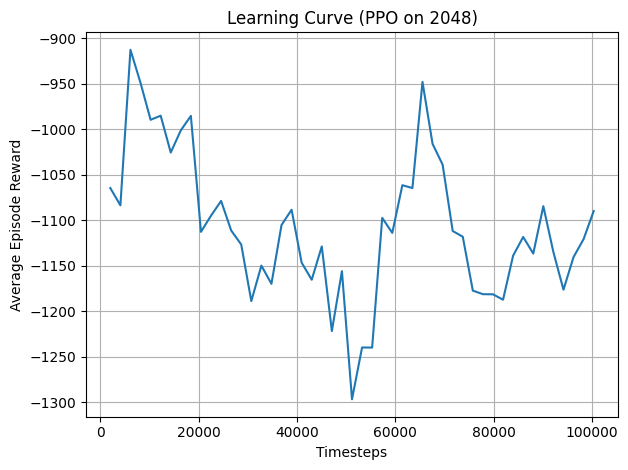

In [11]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os

log_path = "./ppo_2048_tensorboard/PPO_8"
event_file = [f for f in os.listdir(log_path) if f.startswith("events.out")][0]
ea = EventAccumulator(os.path.join(log_path, event_file))
ea.Reload()

events = ea.Scalars("rollout/ep_rew_mean")
steps = [e.step for e in events]
rewards = [e.value for e in events]

plt.plot(steps, rewards)
plt.xlabel("Timesteps")
plt.ylabel("Average Episode Reward")
plt.title("Learning Curve (PPO on 2048)")
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve7.png")
plt.show()


In [18]:
scores = []
max_tiles = []

for _ in range(10):
    game = Board2048()
    done = False
    obs, _ = game.reset()
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = game.step(action)
    scores.append(game.total_score)
    max_tiles.append(game.max_tile)

print(f"Average score: {np.mean(scores):.2f}")
print(f"Average max tile: {np.mean(max_tiles):.2f}")

KeyboardInterrupt: 